# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제 
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8) 

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=5)
    
- `Strong Augment`: CutMix(patch=2)
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: None
    
- `Batch Size`: 16
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam


In [64]:
!pip install tensorflow==2.15.0

In [65]:
import os
import gc 
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None
LOAD_SEGMENTATION_FROM = '/kaggle/input/cxr-unet/'

tensorflow version:  2.15.0
Using 2 GPUs


In [66]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [67]:
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [68]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [69]:
df = pd.read_csv('/kaggle/input/pc-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle','input','pc-dataset','lung_diseases','*','*.png'))}
df['path'] = df['Image Index'].map(tmp)
df = df.rename(columns={'Labels': 'Finding Labels', 'ImageID':'Image Index','Projection':'view'})

In [70]:
df= df[df['Patient Age'] >= 16]
age_below_16 = df[df['Patient Age'] < 16]
if age_below_16.empty:
    print("16세 이하 데이터가 모두 제거되었습니다.")
else:
    print(f"제거되지 않은 16세 이하 데이터가 있습니다: {len(age_below_16)}개")
    display(age_below_16.head())

16세 이하 데이터가 모두 제거되었습니다.


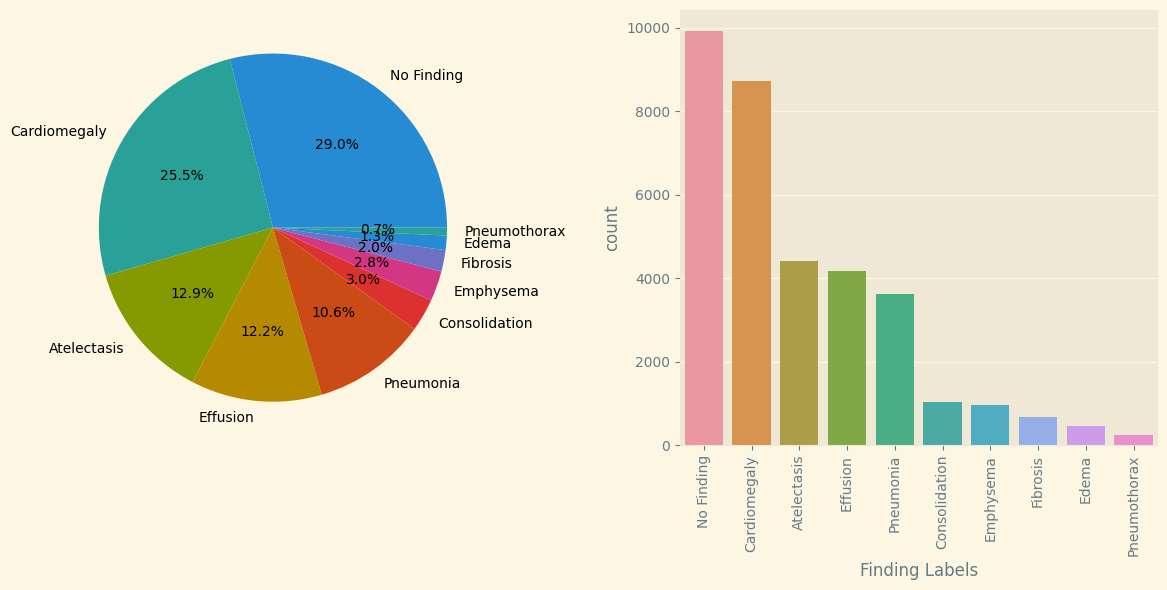

In [71]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [72]:
def parent_level(row):
    if row in ['No Finding']:
        return 'Parent_No Finding'
    elif row in ['Edema','Atelectasis','Pneumonia','Emphysema','Consolidation','Fibrosis']:
        return 'Parent_Lung Opacity'
    elif row in ['Pneumothorax','Effusion']:
        return 'Parent_Pleural'
    else:
        return 'Parent_Cardiomegaly'

In [73]:
tmp = df['Finding Labels'].str.split('|').explode().apply(lambda x: parent_level(x))
tmp2 = tmp.groupby(tmp.index).agg(lambda x: '|'.join(x))
df['Parent Labels'] = tmp2

In [74]:
for label in ['Parent_No Finding', 'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly']:
    df[label] = df['Parent Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

PARENT_TARGET=df.columns[-4:].tolist()
print(PARENT_TARGET)

['Parent_No Finding', 'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly']


In [75]:
allowed_labels = ['No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
                  'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis']

for label in allowed_labels:
    df[label] = df['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

In [76]:
print('Parent Label is', PARENT_TARGET)
LUNG_TARGET = ['Edema','Atelectasis','Pneumonia','Emphysema','Consolidation','Fibrosis']
print('Lung Opacity Label is', LUNG_TARGET)
PLEURAL_TARGET = ['Pneumothorax','Effusion']
print('Pleural Label is', PLEURAL_TARGET)
TARGET = ['No Finding','Edema','Atelectasis','Pneumonia','Emphysema','Consolidation','Fibrosis','Pneumothorax','Effusion', 'Cardiomegaly']
print('Total Label is', TARGET)

Parent Label is ['Parent_No Finding', 'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly']
Lung Opacity Label is ['Edema', 'Atelectasis', 'Pneumonia', 'Emphysema', 'Consolidation', 'Fibrosis']
Pleural Label is ['Pneumothorax', 'Effusion']
Total Label is ['No Finding', 'Edema', 'Atelectasis', 'Pneumonia', 'Emphysema', 'Consolidation', 'Fibrosis', 'Pneumothorax', 'Effusion', 'Cardiomegaly']


**Train & Test Split**

In [77]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. CheXmask model</b></div>

In [78]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from glob import glob

In [79]:
! pip install torch_geometric==2.3.0

In [80]:
import torch

# 현재 사용 중인 디바이스 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 디바이스 정보 출력
print(f"Current device: {device}")

# GPU가 사용 가능한지 확인
if torch.cuda.is_available():
    # 사용 중인 GPU 개수 출력
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    
    # 각 GPU의 이름 및 메모리 정보 출력
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / (1024 ** 3)  # GB 단위로 변환
        print(f"GPU {i}: {gpu_name}, Memory: {gpu_memory:.2f} GB")
else:
    print("No GPU available, using CPU.")

Current device: cuda:0
Number of GPUs available: 2
GPU 0: Tesla T4, Memory: 14.74 GB
GPU 1: Tesla T4, Memory: 14.74 GB


In [81]:
import numpy as np
import scipy.sparse as sp
import torch

def scipy_to_torch_sparse(scp_matrix):
    values = scp_matrix.data
    indices = np.vstack((scp_matrix.row, scp_matrix.col))
    i = torch.LongTensor(indices)
    v = torch.FloatTensor(values)
    shape = scp_matrix.shape

    sparse_tensor = torch.sparse.FloatTensor(i, v, torch.Size(shape))
    return sparse_tensor

## Adjacency Matrix
def mOrgan(N):
    sub = np.zeros([N, N])
    for i in range(0, N):
        sub[i, i-1] = 1
        sub[i, (i+1)%N] = 1
    return sub

## Downsampling Matrix
def mOrganD(N):
    N2 = int(np.ceil(N/2))
    sub = np.zeros([N2, N])
    
    for i in range(0, N2):
        if (2*i+1) == N:
            sub[i, 2*i] = 1
        else:
            sub[i, 2*i] = 1/2
            sub[i, 2*i+1] = 1/2
            
    return sub

def mOrganU(N):
    N2 = int(np.ceil(N/2))
    sub = np.zeros([N, N2])
    
    for i in range(0, N):
        if i % 2 == 0:
            sub[i, i//2] = 1
        else:
            sub[i, i//2] = 1/2
            sub[i, (i//2 + 1) % N2] = 1/2
            
    return sub

def genMatrixesLungsHeart():       
    RLUNG = 44
    LLUNG = 50
    HEART = 26
    
    Asub1 = mOrgan(RLUNG)
    Asub2 = mOrgan(LLUNG)
    Asub3 = mOrgan(HEART)
    
    ADsub1 = mOrgan(int(np.ceil(RLUNG / 2)))
    ADsub2 = mOrgan(int(np.ceil(LLUNG / 2)))
    ADsub3 = mOrgan(int(np.ceil(HEART / 2)))
                    
    Dsub1 = mOrganD(RLUNG)
    Dsub2 = mOrganD(LLUNG)
    Dsub3 = mOrganD(HEART)
    
    Usub1 = mOrganU(RLUNG)
    Usub2 = mOrganU(LLUNG)
    Usub3 = mOrganU(HEART)
        
    p1 = RLUNG
    p2 = p1 + LLUNG
    p3 = p2 + HEART
    
    p1_ = int(np.ceil(RLUNG / 2))
    p2_ = p1_ + int(np.ceil(LLUNG / 2))
    p3_ = p2_ + int(np.ceil(HEART / 2))
    
    A = np.zeros([p3, p3])
    
    A[:p1, :p1] = Asub1
    A[p1:p2, p1:p2] = Asub2
    A[p2:p3, p2:p3] = Asub3
    
    AD = np.zeros([p3_, p3_])
    
    AD[:p1_, :p1_] = ADsub1
    AD[p1_:p2_, p1_:p2_] = ADsub2
    AD[p2_:p3_, p2_:p3_] = ADsub3
   
    D = np.zeros([p3_, p3])
    
    D[:p1_, :p1] = Dsub1
    D[p1_:p2_, p1:p2] = Dsub2
    D[p2_:p3_, p2:p3] = Dsub3
    
    U = np.zeros([p3, p3_])
    
    U[:p1, :p1_] = Usub1
    U[p1:p2, p1_:p2_] = Usub2
    U[p2:p3, p2_:p3_] = Usub3
    
    return A, AD, D, U

In [82]:
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.cheb_conv import ChebConv
from torch_geometric.nn.inits import zeros, normal

# We change the default initialization from zeros to a normal distribution
class ChebConv(ChebConv):
    def reset_parameters(self):
        for lin in self.lins:
            normal(lin, mean = 0, std = 0.1)
            #lin.reset_parameters()
        normal(self.bias, mean = 0, std = 0.1)
        #zeros(self.bias)

# Pooling from COMA: https://github.com/pixelite1201/pytorch_coma/blob/master/layers.py
class Pool(MessagePassing):
    def __init__(self):
        # source_to_target is the default value for flow, but is specified here for explicitness
        super(Pool, self).__init__(flow='source_to_target')

    def forward(self, x, pool_mat,  dtype=None):
        pool_mat = pool_mat.transpose(0, 1)
        out = self.propagate(edge_index=pool_mat._indices(), x=x, norm=pool_mat._values(), size=pool_mat.size())
        return out

    def message(self, x_j, norm):
        return norm.view(1, -1, 1) * x_j
    
    
import torch.nn as nn
import torch.nn.functional as F

class residualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(residualBlock, self).__init__()

        self.skip = nn.Sequential()

        if stride != 1 or in_channels != out_channels:
          self.skip = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels, track_running_stats=False))
        else:
          self.skip = None

        self.block = nn.Sequential(nn.BatchNorm2d(in_channels, track_running_stats=False),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(in_channels, out_channels, 3, padding=1),
                                   nn.BatchNorm2d(out_channels, track_running_stats=False),
                                   nn.ReLU(inplace=True),
                                   nn.Conv2d(out_channels, out_channels, 3, padding=1)
                                   )   

    def forward(self, x):
        identity = x
        out = self.block(x)

        if self.skip is not None:
            identity = self.skip(x)

        out += identity
        out = F.relu(out)

        return out

In [83]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.ops.roi_align as roi_align

import numpy as np

class EncoderConv(nn.Module):
    def __init__(self, latents = 64, hw = 32):
        super(EncoderConv, self).__init__()
        
        self.latents = latents
        self.c = 4
        
        self.size = self.c * np.array([2,4,8,16,32], dtype = np.intc)
        
        self.maxpool = nn.MaxPool2d(2)
        
        self.dconv_down1 = residualBlock(1, self.size[0])
        self.dconv_down2 = residualBlock(self.size[0], self.size[1])
        self.dconv_down3 = residualBlock(self.size[1], self.size[2])
        self.dconv_down4 = residualBlock(self.size[2], self.size[3])
        self.dconv_down5 = residualBlock(self.size[3], self.size[4])
        self.dconv_down6 = residualBlock(self.size[4], self.size[4])
        
        self.fc_mu = nn.Linear(in_features=self.size[4]*hw*hw, out_features=self.latents)
        self.fc_logvar = nn.Linear(in_features=self.size[4]*hw*hw, out_features=self.latents)

    def forward(self, x):
        x = self.dconv_down1(x)
        x = self.maxpool(x)

        x = self.dconv_down2(x)
        x = self.maxpool(x)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)
        
        conv5 = self.dconv_down5(x)
        x = self.maxpool(conv5)
        
        conv6 = self.dconv_down6(x)
        
        x = conv6.view(conv6.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
                
        return x_mu, x_logvar, conv6, conv5


class SkipBlock(nn.Module):
    def __init__(self, in_filters, window):
        super(SkipBlock, self).__init__()
        
        self.window = window
        self.graphConv_pre = ChebConv(in_filters, 2, 1, bias = False) 
    
    def lookup(self, pos, layer, salida = (1,1)):
        B = pos.shape[0]
        N = pos.shape[1]
        F = layer.shape[1]
        h = layer.shape[-1]
        
        ## Scale from [0,1] to [0, h]
        pos = pos * h
        
        _x1 = (self.window[0] // 2) * 1.0
        _x2 = (self.window[0] // 2 + 1) * 1.0
        _y1 = (self.window[1] // 2) * 1.0
        _y2 = (self.window[1] // 2 + 1) * 1.0
        
        boxes = []
        for batch in range(0, B):
            x1 = pos[batch,:,0].reshape(-1, 1) - _x1
            x2 = pos[batch,:,0].reshape(-1, 1) + _x2
            y1 = pos[batch,:,1].reshape(-1, 1) - _y1
            y2 = pos[batch,:,1].reshape(-1, 1) + _y2
            
            aux = torch.cat([x1, y1, x2, y2], axis = 1)            
            boxes.append(aux)
                    
        skip = roi_align(layer, boxes, output_size = salida, aligned=True)
        vista = skip.view([B, N, -1])

        return vista
    
    def forward(self, x, adj, conv_layer):
        pos = self.graphConv_pre(x, adj)
        skip = self.lookup(pos, conv_layer)
        
        return torch.cat((x, skip, pos), axis = 2), pos
        
    
class Hybrid(nn.Module):
    def __init__(self, config, downsample_matrices, upsample_matrices, adjacency_matrices):
        super(Hybrid, self).__init__()
        
        self.config = config
        hw = config['inputsize'] // 32
        self.z = config['latents']
        self.encoder = EncoderConv(latents = self.z, hw = hw)
        
        self.downsample_matrices = downsample_matrices
        self.upsample_matrices = upsample_matrices
        self.adjacency_matrices = adjacency_matrices
        self.kld_weight = 1e-5
                
        n_nodes = config['n_nodes']
        self.filters = config['filters']
        self.K = 6
        self.window = (3,3)
        
        # Genero la capa fully connected del decoder
        outshape = self.filters[-1] * n_nodes[-1]          
        self.dec_lin = torch.nn.Linear(self.z, outshape)
                
        self.normalization2u = torch.nn.InstanceNorm1d(self.filters[1])
        self.normalization3u = torch.nn.InstanceNorm1d(self.filters[2])
        self.normalization4u = torch.nn.InstanceNorm1d(self.filters[3])
        self.normalization5u = torch.nn.InstanceNorm1d(self.filters[4])
        self.normalization6u = torch.nn.InstanceNorm1d(self.filters[5])
        
        outsize1 = self.encoder.size[4]
        outsize2 = self.encoder.size[4]  
                     
        # Guardo las capas de convoluciones en grafo
        self.graphConv_up6 = ChebConv(self.filters[6], self.filters[5], self.K)
        self.graphConv_up5 = ChebConv(self.filters[5], self.filters[4], self.K)       
        
        self.SC_1 = SkipBlock(self.filters[4], self.window)
        
        self.graphConv_up4 = ChebConv(self.filters[4] + outsize1 + 2, self.filters[3], self.K)        
        self.graphConv_up3 = ChebConv(self.filters[3], self.filters[2], self.K)
        
        self.SC_2 = SkipBlock(self.filters[2], self.window)
        
        self.graphConv_up2 = ChebConv(self.filters[2] + outsize2 + 2, self.filters[1], self.K)
        self.graphConv_up1 = ChebConv(self.filters[1], self.filters[0], 1, bias = False)
                
        self.pool = Pool()
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.normal_(self.dec_lin.weight, 0, 0.1)


    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 
    
        
    def forward(self, x):
        self.mu, self.log_var, conv6, conv5 = self.encoder(x)

        if self.training:
            z = self.sampling(self.mu, self.log_var)
        else:
            z = self.mu
            
        x = self.dec_lin(z)
        x = F.relu(x)
        
        x = x.reshape(x.shape[0], -1, self.filters[-1])
        
        x = self.graphConv_up6(x, self.adjacency_matrices[5]._indices())
        x = self.normalization6u(x)
        x = F.relu(x)
        
        x = self.graphConv_up5(x, self.adjacency_matrices[4]._indices())
        x = self.normalization5u(x)
        x = F.relu(x)
        
        x, pos1 = self.SC_1(x, self.adjacency_matrices[3]._indices(), conv6)
        
        x = self.graphConv_up4(x, self.adjacency_matrices[3]._indices())
        x = self.normalization4u(x)
        x = F.relu(x)
        
        x = self.pool(x, self.upsample_matrices[0])
        
        x = self.graphConv_up3(x, self.adjacency_matrices[2]._indices())
        x = self.normalization3u(x)
        x = F.relu(x)
        
        x, pos2 = self.SC_2(x, self.adjacency_matrices[1]._indices(), conv5)
        
        x = self.graphConv_up2(x, self.adjacency_matrices[1]._indices())
        x = self.normalization2u(x)
        x = F.relu(x)
        
        x = self.graphConv_up1(x, self.adjacency_matrices[0]._indices()) # Sin relu y sin bias
        
        return x, pos1, pos2

In [84]:
import numpy as np
import cv2 
import torch
import scipy.sparse as sp

def loadModel(device):    
    A, AD, D, U = genMatrixesLungsHeart()
    N1 = A.shape[0]
    N2 = AD.shape[0]

    A = sp.csc_matrix(A).tocoo()
    AD = sp.csc_matrix(AD).tocoo()
    D = sp.csc_matrix(D).tocoo()
    U = sp.csc_matrix(U).tocoo()

    D_ = [D.copy()]
    U_ = [U.copy()]

    config = {}

    config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
    A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
    
    A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

    config['latents'] = 64
    config['inputsize'] = 1024

    f = 32
    config['filters'] = [2, f, f, f, f//2, f//2, f//2]
    config['skip_features'] = f

    hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
    hybrid.load_state_dict(torch.load('/kaggle/input/chexmask-weights/SegmentationModel/bestMSE.pt', map_location=torch.device(device), weights_only=True))
    hybrid.eval()
    
    return hybrid



In [85]:
def preprocess(input_img):
    img = cv2.resize(input_img, (1024, 1024), interpolation=cv2.INTER_CUBIC)
    return img


def segment(input_image):
    hybrid = loadModel(device)

    if len(input_image.shape) == 3 and input_image.shape[2] == 3:
        #print(input_image.shape)
        input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
        #print(input_image.shape)
        
    input_img = input_image / 255.0
    original_shape = input_img.shape[:2]
    
    img = preprocess(input_img)
    #print(img.shape)
    data = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device).float()
    #print(data.shape)
    with torch.no_grad():
        output = hybrid(data)[0].cpu().numpy().reshape(-1, 2)
    
    output = output * original_shape[0]  # Scale back to original size
    output = output.astype('int')
    
    # Generate the overlapped image
    overlapped_image = drawOnTop(input_img, output)
    
    return output, overlapped_image

def getDenseMask(landmarks, h, w):
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    img = np.zeros([h, w], dtype = 'uint8')
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 1, -1)
    img = cv2.drawContours(img, [LL], -1, 1, -1)
    img = cv2.drawContours(img, [H], -1, 2, -1)
    
    return img

def drawOnTop(img, landmarks):
    h, w = img.shape[:2]
    output = getDenseMask(landmarks, h, w)
    
    image = np.zeros([h, w, 3])
    image[:,:,0] = img + 0.3 * (output == 1).astype('float') - 0.1 * (output == 2).astype('float')
    image[:,:,1] = img + 0.3 * (output == 2).astype('float') - 0.1 * (output == 1).astype('float') 
    image[:,:,2] = img - 0.1 * (output == 1).astype('float') - 0.2 * (output == 2).astype('float') 

    image = np.clip(image, 0, 1)
    
    RL, LL, H = landmarks[0:44], landmarks[44:94], landmarks[94:]
    
    # Draw the landmarks as dots
    for l in RL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in LL:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 0, 1), -1)
    for l in H:
        image = cv2.circle(image, (int(l[0]), int(l[1])), 5, (1, 1, 0), -1)
    
    return image



# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build DataGenerator</b></div>

In [86]:
import albumentations as albu
print(albu.__version__)

1.4.17


In [87]:
import cv2 
import matplotlib.pyplot as plt
def visualizeImg(image):

    # 이미지 시각화
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')  
    plt.axis('off')  # 축 제거
    plt.show()  # 이미지 출력

In [88]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, 
                 preprocess=None, segment_function=None, dense_mask_function=None, lungOnly=False, direction='None'):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.preprocess = preprocess
        self.segment_function = segment_function
        self.dense_mask_function = dense_mask_function
        self.lungOnly= lungOnly
        self.direction = direction
        self.on_epoch_end()
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        # Drop_Last = False
        return int(np.ceil(len(self.data) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(indexes)
        # 전처리 수행 (optional)
        if self.preprocess is not None:
            X = self.preprocess(X)
            
        # 증강 수행
        if self.augment1:
            X = self.__augment1(X)
        if self.augment2:
            X = self.__augment2(X)
            
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, indexes):
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        if self.data['Finding Labels'].str.split('|').explode().nunique() == 10:
            y = np.zeros((len(indexes),len(PARENT_TARGET)), dtype='float32')
        elif self.data['Finding Labels'].str.split('|').explode().nunique() == 6:
            y = np.zeros((len(indexes),len(LUNG_TARGET)), dtype='float32')
        elif self.data['Finding Labels'].str.split('|').explode().nunique() == 2:
            y = np.zeros((len(indexes),len(PLEURAL_TARGET)), dtype='float32')

        for j, i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            img = np.array(Image.open(path))
            img = (img / 65536.0 * 255).astype(np.uint8)
            img = Image.fromarray(img)
            img = img.resize((256, 256), Image.Resampling.LANCZOS)
            img = np.array(img)
            img = img.astype(np.uint8)
            img = self.clahe.apply(img)
            img = np.expand_dims(img, axis=-1)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            img = self.__fill_nan(img)

            lung_mask = self.__segmentation(img)
            
            if(self.lungOnly):
                _, img= self.__crop_lung_mask(img, lung_mask)
            else:
                img, _= self.__crop_lung_mask(img, lung_mask)
                
            if img.shape[:2] != (256, 256):
                img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

            img = img / 255.0
            
            X[j,:,:] = img
            if self.data['Finding Labels'].str.split('|').explode().nunique() == 10:
                y[j,] = row[PARENT_TARGET]
            elif self.data['Finding Labels'].str.split('|').explode().nunique() == 6:
                y[j,] = row[LUNG_TARGET]
            elif self.data['Finding Labels'].str.split('|').explode().nunique() == 2:
                y[j,] = row[PLEURAL_TARGET]
        

        #print(f"X:{X.shape}, y:{y.shape}")
        return X, y

    def __fill_nan(self, img):
        m = np.nanmean(img)
        return np.nan_to_num(img, nan=m)
    
    def __segmentation(self, xray_image):
        if self.segment_function is None or self.dense_mask_function is None:
            raise ValueError("Segmentation function and dense mask function must be provided.")
        
        # 폐 마스크 생성
        landmarks, _ = self.segment_function(xray_image)
        lung_mask = self.dense_mask_function(landmarks, xray_image.shape[0], xray_image.shape[1])
        return lung_mask
    
    def __crop_lung_mask(self, xray_image, lung_mask):
        # 마스크의 외곽선을 찾음
        contours, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # 외곽선이 존재하는지 확인
        if len(contours) == 0:
            print("No contours found in the lung mask.")
            return xray_image, lung_mask  # 마스크가 없으면 원본 이미지 반환

        # 가장 큰 외곽선을 선택
        largest_contour = max(contours, key=cv2.contourArea)

        # 외곽선을 기준으로 bounding box 계산
        x, y, w, h = cv2.boundingRect(largest_contour)

        # 원본 X-ray 이미지와 마스크가 겹치는 부분만 남기기
        masked_xray_image = cv2.bitwise_and(xray_image, xray_image, mask=lung_mask)

        # 자를 방향에 따라 X-ray 이미지와 마스크를 동일한 방식으로 자름
        if self.direction == 'both':
            cropped_image = xray_image[y:y+h, x:x+w]
            cropped_mask = masked_xray_image[y:y+h, x:x+w]
        elif self.direction == 'width':
            cropped_image = xray_image[:, x:x+w]
            cropped_mask = masked_xray_image[:, x:x+w]
        elif self.direction == 'height':
            cropped_image = xray_image[y:y+h, :]
            cropped_mask = masked_xray_image[y:y+h, :]
        elif(self.direction == 'None'):
            return xray_image, masked_xray_image
        
        return cropped_image, cropped_mask

    def __augment1(self, img_batch):
        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)], p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)], p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    def __augment2(self, img_batch, cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:  
                for _ in range(num_patches):
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)
                    
                    cut_width = min(int(width * lam), width // 5)
                    cut_height = min(int(height * lam), height // 5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = \
                        img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]
            
        return img_batch

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Build EfficientNet Model</b></div>

### install efficientnet

In [89]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

### install vit

In [90]:
!pip install -q tfimm

import tfimm

In [91]:
 preprocessing = tfimm.create_preprocessing('cait_s24_224', dtype="float32")

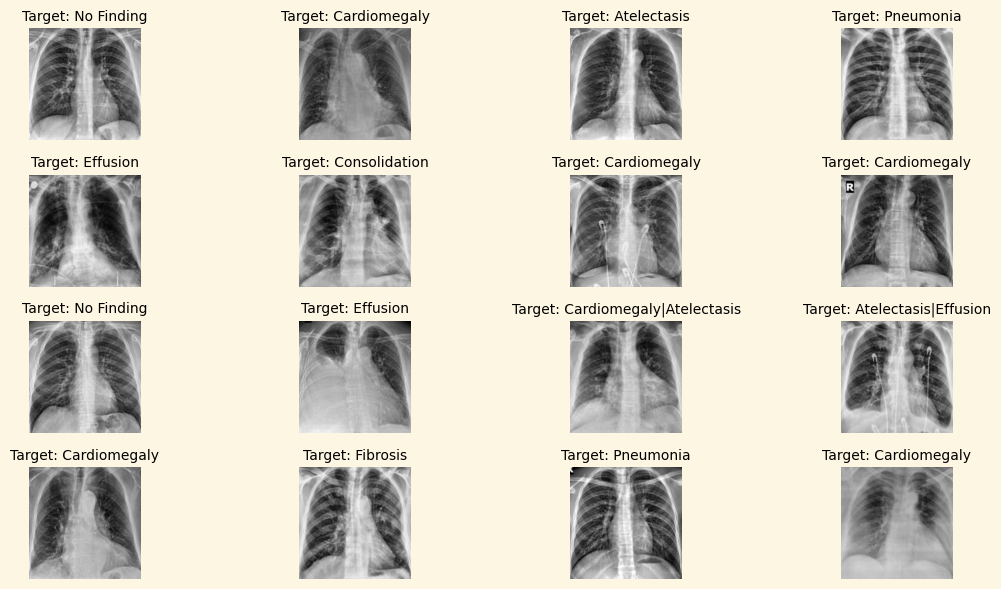

In [92]:
ROWS = 4; COLS = 4; BATCHES = 1

#direction: both, width, height 중 하나. >> 자르는 기준
#lungOnly: 페&심장 영역만 추출
gen = DataGenerator(df_train,batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None, 
                    segment_function=segment, dense_mask_function=getDenseMask, lungOnly=False, direction='both')

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'Target: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            #img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

In [93]:
def build_model():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    cait_model = tfimm.create_model('cait_s24_224', in_channels=3, nb_classes=0, pretrained=True, 
                                     input_size=(256,256))
    
    eff_out = eff_model(inp)
    eff_out = layers.GlobalAveragePooling2D()(eff_out)
   
    cait_out = cait_model(inp)
    cait_out = layers.RepeatVector(5)(cait_out)
    
    cait_out = layers.Bidirectional(
               layers.LSTM(cait_out.shape[-1]//2, return_sequences=False)
    )(cait_out)
    
    x = layers.Concatenate(axis=-1)([cait_out, eff_out])
    
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='Hybrid')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] *6
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [94]:
def parent_model():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    cait_model = tfimm.create_model('cait_s24_224', in_channels=3, nb_classes=0, pretrained=True, 
                                     input_size=(256,256))
    
    eff_out = eff_model(inp)
    eff_out = layers.GlobalAveragePooling2D()(eff_out)
    
    cait_out = cait_model(inp)
    cait_out = layers.RepeatVector(5)(cait_out)
    
    cait_out = layers.Bidirectional(
               layers.LSTM(cait_out.shape[-1]//2, return_sequences=False)
    )(cait_out)
    
    x = layers.Concatenate(axis=-1)([cait_out, eff_out])
    x = layers.Dense(len(PARENT_TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='Hybrid')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 4
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [95]:
def lung_model():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    cait_model = tfimm.create_model('cait_s24_224', in_channels=3, nb_classes=0, pretrained=True, 
                                     input_size=(256,256))
    eff_out = eff_model(inp)
    eff_out = layers.GlobalAveragePooling2D()(eff_out)
    
    cait_out = cait_model(inp)
    cait_out = layers.RepeatVector(5)(cait_out)
    
    cait_out = layers.Bidirectional(
               layers.LSTM(cait_out.shape[-1]//2, return_sequences=False)
    )(cait_out)
    
    x = layers.Concatenate(axis=-1)([cait_out, eff_out])
    x = layers.Dense(len(LUNG_TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='Hybrid')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 6
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [96]:
def pleural_model():
    inp = layers.Input(shape=(256,256,3))
    base_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    base_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    
    base_out = base_model(inp)
    
    x = layers.GlobalAveragePooling2D()(base_out)
    x = layers.Dense(len(PLEURAL_TARGET), activation='sigmoid', dtype='float32')(x)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='efficientnet')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * 2
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [97]:
from tensorflow.keras.utils import plot_model
K.clear_session()
model = lung_model()
model.summary()

#plot_model(model, show_shapes=True, show_layer_names=True)

Model: "Hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 cait_s24_224 (CaiT)         (None, 384)                  4655424   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 repeat_vector (RepeatVecto  (None, 5, 384)               0         ['cait_s24_224[0][0]']        
 r)                                                                                               
                                                                                             

In [98]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. Train CNN Model</b></div>

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6-1. Without cutting</b></div>

In [105]:
tmp = df_train[df_train['Finding Labels'].apply(lambda x: all(label in LUNG_TARGET for label in x.split('|')))]
tmp = tmp.reset_index(drop=True)
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(tmp, groups=tmp['Patient ID'])):
    tmp.loc[valid_index, 'Fold'] = i

In [107]:
print(df_train.columns)

Index(['Image Index', 'Patient ID', 'View Position', 'Finding Labels',
       'Patient Age', 'path', 'Parent Labels', 'Parent_No Finding',
       'Parent_Lung Opacity', 'Parent_Pleural', 'Parent_Cardiomegaly',
       'No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
       'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis'],
      dtype='object')


In [110]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    train_gen = DataGenerator(tmp[tmp['Fold'] != i], batch_size=8, shuffle=True, 
                              augment1=True, augment2=True, preprocess=efn.preprocess_input,
                              segment_function=segment, dense_mask_function=getDenseMask, 
                             lungOnly=True, direction='both')
    valid_gen = DataGenerator(tmp[tmp['Fold'] == i], batch_size=8,shuffle=False, 
                              augment1=True, augment2=True, preprocess=efn.preprocess_input,
                              segment_function=segment, dense_mask_function=getDenseMask,
                              lungOnly=True, direction='both'
                             )

    print(f'### train size {len(tmp[tmp["Fold"] != i])}, valid size {len(tmp[tmp["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = lung_model()

    # TensorFlow가 GPU를 인식하고 있는지 확인
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    print("TensorFlow is using GPU:", tf.test.is_gpu_available())

    # 모델이 실행 중인 디바이스를 확인
    tf.debugging.set_log_device_placement(True)    
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'Hybrid_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(tmp[tmp['Fold'] == i][TARGET].values)
    all_index.append(tmp[tmp['Fold'] == i]['Image Index'].values)
    
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 4979, valid size 1245
#########################
Num GPUs Available:  2
TensorFlow is using GPU: True
Epoch 1/10


I0000 00:00:1728397279.175861     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


623/623 [==============================] - 2637s 4s/step - loss: 0.4200 - auc: 0.8086 - val_loss: 0.4629 - val_auc: 0.7576 - lr: 0.0010
Epoch 2/10
623/623 [==============================] - ETA: 0s - loss: 0.3996 - auc: 0.8385
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
623/623 [==============================] - 2294s 4s/step - loss: 0.3996 - auc: 0.8385 - val_loss: 15.0950 - val_auc: 0.5201 - lr: 0.0010
Epoch 3/10
623/623 [==============================] - ETA: 0s - loss: 0.3774 - auc: 0.8671
Epoch 3: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
623/623 [==============================] - 2368s 4s/step - loss: 0.3774 - auc: 0.8671 - val_loss: 0.5284 - val_auc: 0.6848 - lr: 1.0000e-04
Epoch 4/10
623/623 [==============================] - 2376s 4s/step - loss: 0.3676 - auc: 0.8785 - val_loss: 0.3884 - val_auc: 0.8612 - lr: 1.0000e-05
Epoch 5/10
623/623 [==============================] - 2301s 4s/step - loss: 0.3659 - auc: 0.8802 - v

NameError: name 'all_history' is not defined

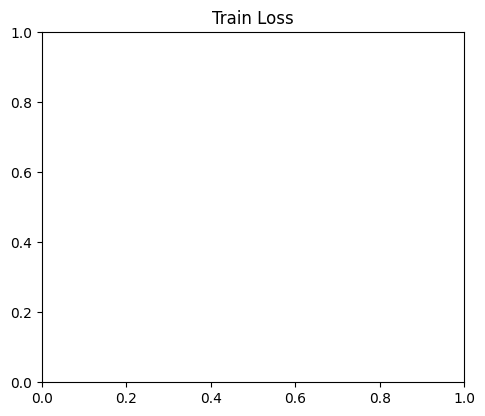

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
plt.title('Train Loss')
for fold, i in enumerate(all_history['Train Loss']):
    plt.plot(i, label=f'Fold {fold}')
    plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,2)
plt.title('Valid Loss')
for fold, i in enumerate(all_history['Valid Loss']):
    plt.plot(i,label=f'Fold {fold}')
    plt.xlabel('Epochs')
plt.legend()

plt.subplot(2,2,3)
plt.title('Train Auc')
for fold, i in enumerate(all_history['Train Auc']):
    plt.plot(i, label=f'Fold {fold}')
    plt.xlabel('Epochs')
plt.legend()
    
plt.subplot(2,2,4)
plt.title('Valid Auc')
for fold, i in enumerate(all_history['Valid Auc']):
    plt.plot(i, label=f'Fold {fold}')
    plt.xlabel('Epochs')
plt.legend()


    
plt.tight_layout()
plt.show()

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()


In [ ]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. Inference</b></div>

In [ ]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    K.clear_session()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
    else: 
        model.load_weights(f'Hybrid_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    

auc_score = roc_auc_score(df_test[TARGET], pred_res, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Test Set =', auc_score)

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>8. 2Stage Model</b></div>

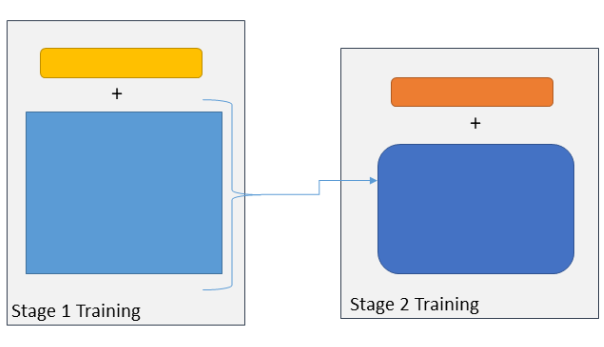

In [ ]:

preds = []

## No TTA
train_gen = DataGenerator(df_train, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()
    model = build_model()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
    else:
        model.load_weights(f'Hybrid_f{i}.weights.h5')
    embedding_model = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)

    pred = embedding_model.predict(train_gen, verbose=1)

    preds.append(pred)
pred = np.mean(preds,axis=0)
train_embedding = pred

df_train = df_train.drop(columns=TARGET)

train_embedding = pd.DataFrame(train_embedding)
train_embedding.columns = [f'embedding_{i}' for i in range(len(train_embedding.columns))]

df_train = pd.concat([df_train, train_embedding], axis=1)
df_train.to_csv('hybrid_train.csv', index=False)

In [ ]:
preds = []

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=64, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}')
    K.clear_session()
    model = build_model()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
    else:
        model.load_weights(f'Hybrid_f{i}.weights.h5')
    embedding_model = Model(inputs=model.input, outputs=model.get_layer('concatenate').output)

    pred = embedding_model.predict(test_gen, verbose=1)

    preds.append(pred)

pred = np.mean(preds,axis=0)
test_embedding = pred


df_test = df_test.drop(columns=TARGET)

test_embedding = pd.DataFrame(test_embedding)
test_embedding.columns = [f'embedding_{i}' for i in range(len(test_embedding.columns))]

df_test = pd.concat([df_test, test_embedding], axis=1)
df_test.to_csv('hybrid_test.csv', index=False)